<a href="https://colab.research.google.com/github/GergelyTuri/fiberphotometry/blob/main/notebooks/calcium_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calcum analysis
* 8/30/2023 setting up
* 9/26/23 working on the fiberphot data class
* 9/27/23 class seems to be working

In [1]:
!git clone https://github.com/GergelyTuri/fiberphotometry.git
%cd fiberphotometry
!pip install .

Cloning into 'fiberphotometry'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 237 (delta 119), reused 159 (delta 57), pack-reused 0
Receiving objects: 100% (237/237), 23.63 MiB | 34.03 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/fiberphotometry
Processing /content/fiberphotometry
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.1 MB/s eta 0:00:00
  Created wheel for fiber-photometry-analysis: filename=fiber_photometry_analysis-0.1-py3-none-any.whl size=8280 sha256=0db5aadcbae123b7b263cafea15448883c004f21e2508980645e1d1387092426
  Stored in directory: /tmp/pip-ephem-wheel-cache-44rp151a/wheels/4b/b6/cf/916d1f43d06b8bc573d2ec7471e525018bf5ea7bcf83b8e670
Successfully built fiber-photometry-analysis


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from fiberphotometry.src import fiberphotometry as fp

In [3]:
%matplotlib inline

In [43]:
tank_path=['/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056/',
           '/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160741/'
           ]

In [44]:
dfofs = []
for path in tank_path:
    tdt_tank = fp.FiberPhotometry(path)
    dfofs.append(tdt_tank.calculate_deltaF_F())

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056/Notes.txt
read from t=0s to t=365.35s
Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160741/Notes.txt
read from t=0s to t=301.95s


In [55]:
print(len(dfofs[0]), len(dfofs[1]))
light = dfofs[0][500:307072]
dark = dfofs[1][500:307072]
dark_auc = metrics.auc(np.linspace(0, len(dark), num=len(dark)), dark)
light_auc = metrics.auc(np.linspace(0, len(light), num=len(light)), light)
print(dark_auc, light_auc)

371584 307072
56.129812757224016 -133.5791613382766


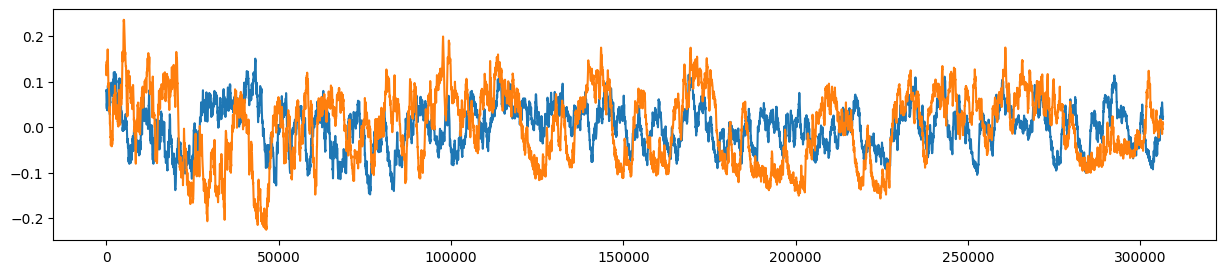

In [56]:
plt.figure(figsize=(15,3))
plt.plot(dfofs[0][500:307072])
# plt.hlines(dark_auc, xmin=0, xmax=len(dfofs[0][500:]), color='r')
plt.plot(dfofs[1][500:307072])
# plt.hlines(light_auc, xmin=0, xmax=len(dfofs[1][500:]), color='k')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


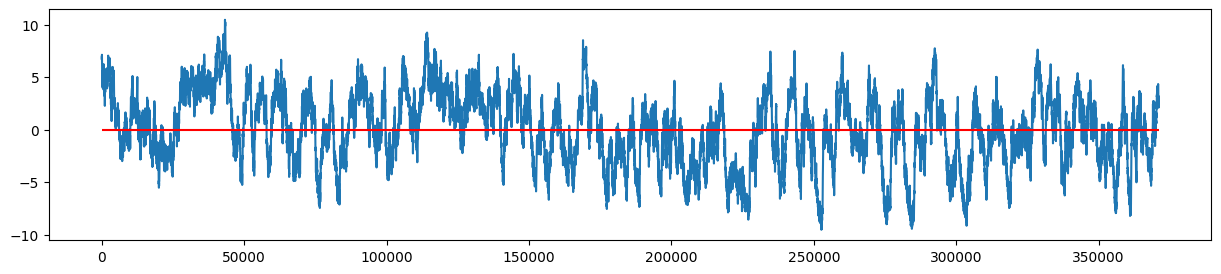

In [38]:
# dfof calc based on TDT handbook.
# pretty much the same result.
y = f_data['streams']['_465A'].data[500:]
x = f_data['streams']['_405A'].data[500:]
bls = np.polyfit(x,y,1)
Y_fit_all  = np.multiply(bls[0],x)+bls[1]
Y_dF_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
sdt_dFF = np.std(dFF)
plt.figure(figsize=(15,3))
plt.plot(dFF)
plt.hlines(np.mean(dFF), xmin=0, xmax=len(dFF), color='r')